In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import bumps

#sys.path.append('/gscratch/stf/caitwolf/sans_fitting/python_install/sasview/src')
import sas

import multiprocessing as mp

In [2]:
# sample meta-data
sample_info = pd.read_csv('../../data/sans/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual volume percentages
data = np.loadtxt('../../data/uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual_vol = {}
actual_stdev_vol = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual_vol[key] = act_vol
    actual_stdev_vol[key] = stdev_vol
    
slds = {'RRe-P3HT':0.676,
       'RRa-P3HT':0.676,
       'P3DDT':0.316,
       'PQT-12':0.676,
       #'Polystyrene-D8':6.407,
       'Polystyrene-D8':6.464, # density of 1.13 g/mL
       'Polystyrene-H8':1.426}

data_dir = '../../data/sans/Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)
        
true_keys = []

true_reads = pd.read_csv('../../data/sans/Fit_Truths.csv')
true_reads = true_reads.to_numpy()
mask1 = true_reads[:,3].astype(bool)
mask2 = true_reads[:,4].astype(bool)

sphere_parallel_keys = true_reads[mask1,0]
ellipsoid_parallel_keys = true_reads[mask2,0]

run_keys = list(np.unique(np.concatenate((sphere_parallel_keys,ellipsoid_parallel_keys))))

background_files = [file for file in os.listdir('../../data/sans/PS_Fitting/ps_fit_results/power_law_background') if 'json' in file]
backgrounds = {} # key is sample key, value is ('best', '95% confidence interval')
for file in background_files:
    data_read = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_background/' + file)
    key = int(file.split('_')[0][3:])
    p95 = data_read.loc['p95',str(key) + ' background']
    backgrounds[key] = (data_read.loc['best',str(key) + ' background'], p95)
    
power_law_fit_info = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/power_law_porod_exp_scale/PS_porod_exp_scale-err.json')
ps_scales = {}

for key, value in power_law_fit_info.items():
    if 'porod_exp' in key:
        ps_porod_exp = value['best']
        ps_porod_exp_95 = value['p95']
    else:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        
guinier_porod_fit = pd.read_json('../../data/sans/PS_Fitting/ps_fit_results/guinier_porod_s_scale/PS_s_scale-err.json')
rgs = {}
adjusted_scales = {}
for key, value in guinier_porod_fit.items():
    if key == 'ps s':
        ps_s = value['best']
        ps_s_95 = value['p95']
    elif 'rg' in key:
        key = int(key.split()[0])
        rgs[key] = (value['best'], value['p95'])
    elif 'scale' in key:
        key = int(key.split()[0])
        ps_scales[key] = (value['best'], value['p95'])
        
for key in rgs.keys():
    q1 = (1/rgs[key][0]) * np.sqrt((ps_porod_exp - ps_s)*(3-ps_s)/2)
    new_scale = ps_scales[key][0] * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    new_95p = np.array(ps_scales[key][1]) * np.exp(-1*q1**2*rgs[key][0]**2/(3-ps_s)) * q1**(ps_porod_exp - ps_s)
    adjusted_scales[key] = (new_scale, list(new_95p))

    
avg_rg = np.average([x[0] for x in rgs.values()])
max_rg = np.max([x[1][1] for x in rgs.values()])
min_rg = np.min([x[1][0] for x in rgs.values()])

avg_scale = np.average([x[0] for y, x in ps_scales.items() if y in rgs.keys()])
max_scale = np.average([x[1][1] for y, x in ps_scales.items() if y in rgs.keys()])
min_scale = np.average([x[1][0] for y, x in ps_scales.items() if y in rgs.keys()])

porod_files = [file for file in os.listdir('../../data/sans/Porod_analysis/porod_results') if 'json' in file]

for file in porod_files:
    data_read = pd.read_json('../../data/sans/Porod_analysis/porod_results/' + file)
    key = int(file.split('_')[0][3:])
    for column, value in data_read.items():
        if 'background' in column:
            backgrounds[key] = (value['best'], value['p95']) 
            
os.makedirs('../../data/sans/Sample_Fitting/fitting_results/ps_sphere_cylinder', exist_ok=True)
run_keys = [key for key in run_keys if key in actual_vol.keys() and key in usans_data.keys()]

In [3]:
kernel = load_model("guinier_porod+sphere+cylinder")
model = Model(kernel)
model.parameters()

{'scale': Parameter(scale),
 'background': Parameter(background),
 'A_scale': Parameter(A_scale),
 'A_rg': Parameter(A_rg),
 'A_s': Parameter(A_s),
 'A_porod_exp': Parameter(A_porod_exp),
 'B_scale': Parameter(B_scale),
 'B_sld': Parameter(B_sld),
 'B_sld_solvent': Parameter(B_sld_solvent),
 'B_radius': Parameter(B_radius),
 'B_radius_pd': Parameter(B_radius_pd),
 'B_radius_pd_n': Parameter(B_radius_pd_n),
 'B_radius_pd_nsigma': Parameter(B_radius_pd_nsigma),
 'C_scale': Parameter(C_scale),
 'C_sld': Parameter(C_sld),
 'C_sld_solvent': Parameter(C_sld_solvent),
 'C_radius': Parameter(C_radius),
 'C_radius_pd': Parameter(C_radius_pd),
 'C_radius_pd_n': Parameter(C_radius_pd_n),
 'C_radius_pd_nsigma': Parameter(C_radius_pd_nsigma),
 'C_length': Parameter(C_length),
 'C_length_pd': Parameter(C_length_pd),
 'C_length_pd_n': Parameter(C_length_pd_n),
 'C_length_pd_nsigma': Parameter(C_length_pd_nsigma),
 'C_theta': Parameter(C_theta),
 'C_theta_pd': Parameter(C_theta_pd),
 'C_theta_pd_n': P

In [ ]:
os.makedirs('../../data/sans/Sample_Fitting/fitting_results/ps_sphere_cylinder_lm', exist_ok=True)


In [98]:
def fit_function(
    key,
    sans_data,
    usans_data,
    actual_vol,
    actual_stdev_vol,
    backgrounds,
    avg_scale,
    avg_rg,
    ps_s,
    ps_porod_exp,
    slds,
    cps,
    matrix):

    #np.savetxt('Sample_'+str(key)+'.txt', np.array(['Fitting']), fmt='%s')
    kernel = load_model("guinier_porod+sphere+cylinder")


    # loading the data
    sans = sans_data[key]
    sans.dx = sans.dx-sans.dx # removing smearing from sans segment
    usans = usans_data[key]

    vol = actual_vol[key]/100 # cp volume fraction from uv-vis
    vol_stdev = actual_stdev_vol[key]/100

    # initial parameter values

    scale = Parameter(1, name=str(key) + 'scale')
    background = Parameter(backgrounds[key][0], name=str(key) + 'background')

    A_scale = Parameter(avg_scale*(1-vol), name=str(key) + ' PS scale')
    A_rg = Parameter(avg_rg, name=str(key) + ' PS rg')
    A_s = Parameter(ps_s, name=str(key) + ' PS s')
    A_porod_exp = Parameter(ps_porod_exp, name=str(key) + ' PS porod_exp')

    scale_ratio = Parameter(0.4, name=str(key) + ' B scale ratio').range(0,1)
    scale_normal = bumps.bounds.Normal(mean=vol, std=vol_stdev)
    cp_scale = Parameter(vol, name=str(key) + ' cp scale', bounds=scale_normal)
    
    B_scale = scale_ratio * cp_scale

    B_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    B_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')

    B_radius = Parameter(2000, limits=[0,inf], name=str(key) + ' sphere radius').range(100,200000)
    B_radius_pd = Parameter(0.5, name = str(key) + ' sphere radius pd')
    B_radius_pd_n = Parameter(200, name = str(key) + ' sphere radius pd n')
    B_radius_pd_nsigma = Parameter(8, name = str(key) + ' sphere radius pd nsigma') 
    
    C_scale = (1-scale_ratio) * cp_scale
    
    C_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    C_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')
        
    C_radius = Parameter(90, limits=[0,inf], name = str(key) + ' cylinder radius').range(10,1000)
    C_radius_pd  = Parameter(0.2, name = str(key) + ' cylinder radius pd')
    C_radius_pd_n = Parameter(200, name = str(key) + ' cylinder radius pd n')
    C_radius_pd_nsigma = Parameter(8, name = str(key) + ' cylinder radius pd nsigma')

    C_length = Parameter(137000, limits=[0,inf], name = str(key) + ' cylinder length').range(10000,300000)
    #C_length = Parameter(200000, limits=[0,inf], name = str(key) + ' length')
    C_length_pd  = Parameter(0, name = str(key) + ' length pd')
    C_length_pd_n = Parameter(200, name = str(key) + ' length pd n')
    C_length_pd_nsigma = Parameter(8, name = str(key) + ' length pd nsigma')
    

    # setting up the combined model for fitting
    sans_model = Model(
        model=kernel,
        scale=scale,
        background=background,
        A_scale=A_scale,
        A_rg=A_rg,
        A_s=A_s,
        A_porod_exp=A_porod_exp,
        B_scale=B_scale,
        B_sld=B_sld,
        B_sld_solvent=B_sld_solvent,
        B_radius=B_radius,
        B_radius_pd_type='lognormal',
        B_radius_pd=B_radius_pd,
        B_radius_pd_n=B_radius_pd_n,
        B_radius_pd_nsigma=B_radius_pd_nsigma,
        C_scale = C_scale,
        C_sld = C_sld,
        C_sld_solvent = C_sld_solvent,
        C_radius = C_radius,
        C_radius_pd_type='lognormal',
        C_radius_pd = C_radius_pd,
        C_radius_pd_n = C_radius_pd_n,
        C_radius_pd_nsigma = C_radius_pd_nsigma,
        C_length = C_length,
        C_length_pd_type='lognormal',
        C_length_pd = C_length_pd,
        C_length_pd_n = C_length_pd_n,
        C_length_pd_nsigma = C_length_pd_nsigma,
    )

    # setting parameter ranges as needed

    sans_experiment=Experiment(data=sans, model=sans_model)
    usans_experiment=Experiment(data=usans, model=sans_model)

    usans_smearing = sasmodels.resolution.Slit1D(usans.x, 0.117)
    usans_experiment.resolution = usans_smearing

    experiment = [sans_experiment, usans_experiment]
    
    problem=FitProblem(experiment, weights=[0.1,0.9])
    
    result=fit(problem, method='lm', verbose=True)
    #result=None
    #result=fit(problem, method='dream', samples=1e6, verbose=True)
    #result.state.save('../data/sans/Sample_Fitting/fitting_results/ps_sphere_parrallelepiped/CMW' + str(key) + '_ps_sphere_parallelepiped_state')
    
    return(problem, result)


final chisq 25.454(25)
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                       401 sphere radius 805(56)         805(78)        
                     401 cylinder length 163.4(72)e3     163(10)e3      
                     401 cylinder radius 107.6(33)       107.6(46)      
                       401 B scale ratio 0.432(26)       0.432(37)      
                            401 cp scale 0.001988(72)    0.00199(10)    


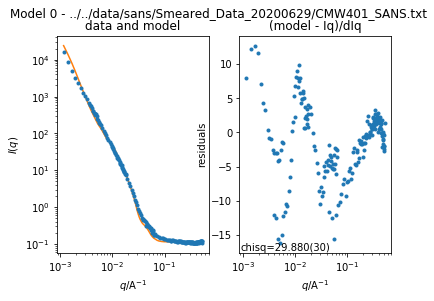

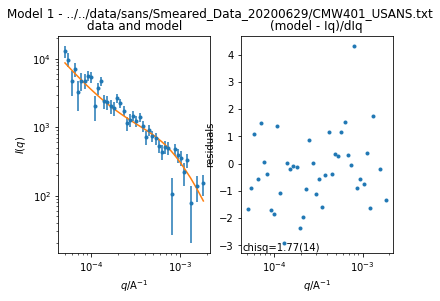

In [99]:
#all_problems = {}

#for key in [key for key in run_keys if key not in [2,3,23,101,102,108,109,301,302,303,401,402]]:
for key in [401]:

    problem, result = fit_function(key, sans_data, usans_data, actual_vol, actual_stdev_vol, backgrounds, avg_scale, avg_rg, ps_s, ps_porod_exp, slds, cps, matrix)
    problem.plot()
    all_problems[key] = (problem, result)

#     params = [str(key) + ' sphere radius',str(key)+' cylinder length',str(key) + ' cylinder radius',str(key) + ' B scale ratio',str(key) + ' cp scale']
#     params = np.array(params)

#     save_results = result.x.astype(str)
#     save_results_dx = result.dx.astype(str)

#     np.savetxt('../../data/sans/Sample_Fitting/fitting_results/ps_sphere_cylinder_lm/CMW' + str(key) + '_results.csv', np.vstack((params,save_results,save_results_dx)).T, delimiter=',', fmt='%s')


In [100]:
problem, result = all_problems[key]

params = [str(key) + ' sphere radius',str(key)+' cylinder length',str(key) + ' cylinder radius',str(key) + ' B scale ratio',str(key) + ' cp scale']
params = np.array(params)

save_results = result.x.astype(str)
save_results_dx = result.dx.astype(str)

np.savetxt('../../data/sans/Sample_Fitting/fitting_results/ps_sphere_cylinder_lm/CMW' + str(key) + '_results.csv', np.vstack((params,save_results,save_results_dx)).T, delimiter=',', fmt='%s')


In [10]:
all_problems = {}

for key in [key for key in run_keys if key not in [2,3,23,101,102,108,109,301,302,303,401,402]]:
#for key in [2,3,23,101,102,108,109,301,302,303,401,402]:

    problem, result = fit_function(key, sans_data, usans_data, actual_vol, actual_stdev_vol, backgrounds, avg_scale, avg_rg, ps_s, ps_porod_exp, slds, cps, matrix)
    #problem.plot()
    all_problems[key] = (problem, result)

    params = [str(key) + ' sphere radius',str(key)+' cylinder length',str(key) + ' cylinder radius',str(key) + ' B scale ratio',str(key) + ' cp scale']
    params = np.array(params)

    save_results = result.x.astype(str)
    save_results_dx = result.dx.astype(str)

    np.savetxt('../../data/sans/Sample_Fitting/fitting_results/ps_sphere_cylinder_lm/CMW' + str(key) + '_results.csv', np.vstack((params,save_results,save_results_dx)).T, delimiter=',', fmt='%s')


final chisq 220.188(19) constraints=407.433
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                         4 sphere radius 1304.1(21)      1304.07(14)    
                       4 cylinder length 117.24(14)e3    117243.8(96)   
                       4 cylinder radius 78.702(73)      78.7019(49)    
                         4 B scale ratio 0.79812(62)     0.798123(42)   
                              4 cp scale 0.06592(16)     0.065922(11)   
final chisq 518.059(19) constraints=991.08
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                         5 sphere radius 2585.0(61)      2584.95(27)    
                       5 cylinder length 123833(98)      123833.4(43)   
                       5 cylinder radius 87.638(46)      87.6383(20)    
                         5 B scale ratio 0.20808(55)     0.208083(24)   
                              5 cp scale 0.053424(44)    0.0534235(19)  
final chisq 407.620(19) con

final chisq 281.477(25) constraints=95.4135
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                       305 sphere radius 4314(15)        4314.49(89)    
                     305 cylinder length 137.54(20)e3    137536(12)     
                     305 cylinder radius 88.937(74)      88.9373(44)    
                       305 B scale ratio 0.5384(11)      0.538351(68)   
                            305 cp scale 0.06803(16)     0.0680265(94)  
final chisq 27.741(25) constraints=638.152
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                       403 sphere radius 233.3(14)       233.27(27)     
                     403 cylinder length 106.05(51)e3    106046(97)     
                     403 cylinder radius 81.98(24)       81.981(46)     
                       403 B scale ratio 0.5520(22)      0.55202(41)    
                            403 cp scale 0.009755(28)    0.0097552(54)  
final chisq 23.967(25) cons

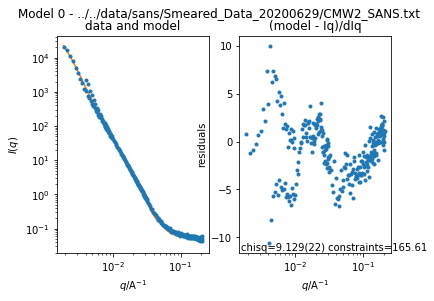

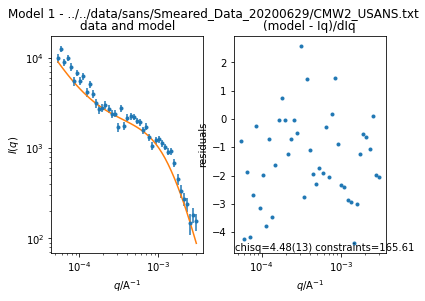

In [9]:
all_problems[2][0].plot()

In [47]:
def fit_function2(
    key,
    sans_data,
    usans_data,
    actual_vol,
    actual_stdev_vol,
    backgrounds,
    avg_scale,
    avg_rg,
    ps_s,
    ps_porod_exp,
    slds,
    cps,
    matrix):

    #np.savetxt('Sample_'+str(key)+'.txt', np.array(['Fitting']), fmt='%s')
    kernel = load_model("guinier_porod+sphere+cylinder")


    # loading the data
    sans = sans_data[key]
    sans.dx = sans.dx-sans.dx # removing smearing from sans segment
    usans = usans_data[key]

    vol = actual_vol[key]/100 # cp volume fraction from uv-vis
    vol_stdev = actual_stdev_vol[key]/100

    # initial parameter values

    scale = Parameter(1, name=str(key) + 'scale')
    background = Parameter(backgrounds[key][0], name=str(key) + 'background')

    A_scale = Parameter(avg_scale*(1-vol), name=str(key) + ' PS scale')
    A_rg = Parameter(avg_rg, name=str(key) + ' PS rg')
    A_s = Parameter(ps_s, name=str(key) + ' PS s')
    A_porod_exp = Parameter(ps_porod_exp, name=str(key) + ' PS porod_exp')

    scale_ratio = Parameter(0.4, name=str(key) + ' B scale ratio').range(0,1)
    scale_normal = bumps.bounds.Normal(mean=vol, std=vol_stdev)
    cp_scale = Parameter(vol, name=str(key) + ' cp scale', bounds=scale_normal)
    
    B_scale = scale_ratio * cp_scale

    B_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    B_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')

    B_radius = Parameter(10000, limits=[0,inf], name=str(key) + ' sphere radius').range(100,200000)
    B_radius_pd = Parameter(0.5, name = str(key) + ' sphere radius pd')
    B_radius_pd_n = Parameter(200, name = str(key) + ' sphere radius pd n')
    B_radius_pd_nsigma = Parameter(8, name = str(key) + ' sphere radius pd nsigma') 
    
    C_scale = (1-scale_ratio) * cp_scale
    
    C_sld = Parameter(slds[cps[key]], name=str(key) + ' PS sld')
    C_sld_solvent = Parameter(slds[matrix[key]], name=str(key) + ' PS solvent')
        
    C_radius = Parameter(70, limits=[0,inf], name = str(key) + ' cylinder radius').range(10,1000)
    C_radius_pd  = Parameter(0.2, name = str(key) + ' cylinder radius pd')
    C_radius_pd_n = Parameter(200, name = str(key) + ' cylinder radius pd n')
    C_radius_pd_nsigma = Parameter(8, name = str(key) + ' cylinder radius pd nsigma')

    C_length = Parameter(20000, limits=[0,inf], name = str(key) + ' cylinder length').range(10000,300000)
    #C_length = Parameter(200000, limits=[0,inf], name = str(key) + ' length')
    C_length_pd  = Parameter(0, name = str(key) + ' length pd')
    C_length_pd_n = Parameter(200, name = str(key) + ' length pd n')
    C_length_pd_nsigma = Parameter(8, name = str(key) + ' length pd nsigma')
    

    # setting up the combined model for fitting
    sans_model = Model(
        model=kernel,
        scale=scale,
        background=background,
        A_scale=A_scale,
        A_rg=A_rg,
        A_s=A_s,
        A_porod_exp=A_porod_exp,
        B_scale=B_scale,
        B_sld=B_sld,
        B_sld_solvent=B_sld_solvent,
        B_radius=B_radius,
        B_radius_pd_type='lognormal',
        B_radius_pd=B_radius_pd,
        B_radius_pd_n=B_radius_pd_n,
        B_radius_pd_nsigma=B_radius_pd_nsigma,
        C_scale = C_scale,
        C_sld = C_sld,
        C_sld_solvent = C_sld_solvent,
        C_radius = C_radius,
        C_radius_pd_type='lognormal',
        C_radius_pd = C_radius_pd,
        C_radius_pd_n = C_radius_pd_n,
        C_radius_pd_nsigma = C_radius_pd_nsigma,
        C_length = C_length,
        C_length_pd_type='lognormal',
        C_length_pd = C_length_pd,
        C_length_pd_n = C_length_pd_n,
        C_length_pd_nsigma = C_length_pd_nsigma,
    )

    # setting parameter ranges as needed

    sans_experiment=Experiment(data=sans, model=sans_model)
    usans_experiment=Experiment(data=usans, model=sans_model)

    usans_smearing = sasmodels.resolution.Slit1D(usans.x, 0.117)
    usans_experiment.resolution = usans_smearing

    experiment = [sans_experiment, usans_experiment]
    
    problem=FitProblem(experiment)
    
    result=fit(problem, method='lm', verbose=True)
    #result=None
    
    #result=fit(problem, method='dream', samples=1e6, verbose=True)
    #result.state.save('../data/sans/Sample_Fitting/fitting_results/ps_sphere_parrallelepiped/CMW' + str(key) + '_ps_sphere_parallelepiped_state')
    
    return(problem, result)


In [48]:
redo_keys = [407]

for key in redo_keys:

    problem, result = fit_function2(key, sans_data, usans_data, actual_vol, actual_stdev_vol, backgrounds, avg_scale, avg_rg, ps_s, ps_porod_exp, slds, cps, matrix)
    #problem.plot()
    all_problems[key] = (problem, result)

    params = [str(key) + ' sphere radius',str(key)+' cylinder length',str(key) + ' cylinder radius',str(key) + ' B scale ratio',str(key) + ' cp scale']
    params = np.array(params)

    print(result.x.astype(str))
    save_results = result.x.astype(str)
    save_results_dx = result.dx.astype(str)

    np.savetxt('../../data/sans/Sample_Fitting/fitting_results/ps_sphere_cylinder_lm/CMW' + str(key) + '_results.csv', np.vstack((params,save_results,save_results_dx)).T, delimiter=',', fmt='%s')


final chisq 11.516(25) constraints=1523.48
=== Uncertainty from curvature:     name value(unc.)     value(unc./chi)) ===
                       407 sphere radius 263.1(27)       263.06(81)     
                     407 cylinder length 28.02(43)e3     28.02(13)e3    
                     407 cylinder radius 95.37(44)       95.37(13)      
                       407 B scale ratio 0.5407(36)      0.5407(11)     
                            407 cp scale 0.003661(17)    0.0036611(51)  
['263.0609423081955' '28016.83882311226' '95.37211500766678'
 '0.5406675633898544' '0.0036610714552290234']


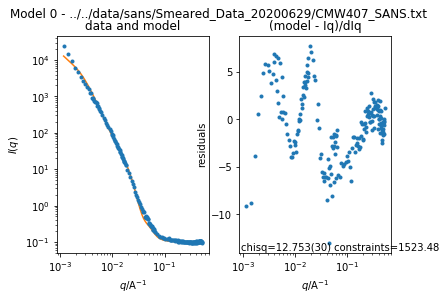

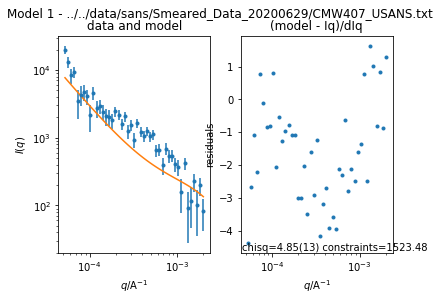

In [49]:
all_problems[407][0].plot()